# Project 4: Bike Sharing

## Introduction

Bike-sharing systems are a new(ish!) generation of traditional bike rentals where the process of signing up, renting, and returning is automated. Using these systems, users can easily rent a bike from one location and return it to another. 

In this assignment, I will clean, visualize, explore, and analyze bike-sharing data from Washington, D.C. I will also investigate open-ended questions.

In [3]:
import csv
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import zipfile
from pathlib import Path
import ds100_utils

# Default plot configurations
%matplotlib inline
plt.rcParams['figure.figsize'] = (16,8)
plt.rcParams['figure.dpi'] = 150
sns.set()

import warnings
warnings.filterwarnings("ignore")

from IPython.display import display, Latex, Markdown

<hr style="border: 5px solid #003262;" />
<hr style="border: 1px solid #fdb515;" />

## Loading Bike Sharing Data
I will explore data collected from a bike-sharing system in Washington, DC.

Here are variables in the data:

Variable       | Description
-------------- | ------------------------------------------------------------------
instant | unique ID
dteday | date
season | 1. spring <br> 2. summer <br> 3. fall <br> 4. winter
yr | year (0: 2011, 1:2012)
mnth | month (1 to 12)
hr | hour (0 to 23)
holiday | whether the day is a holiday or not
weekday | day of the week
workingday | if the day is neither a weekend nor a holiday
weathersit | 1. clear or partly cloudy <br> 2. mist and clouds <br> 3. light snow or rain <br> 4. heavy rain or snow
temp | normalized temperature in Celsius (divided by 41)
atemp | normalized "feels-like" temperature in Celsius (divided by 50)
hum | normalized percent humidity (divided by 100)
windspeed| normalized wind speed (divided by 67)
casual | count of casual users
registered | count of registered users
cnt | count of total rental bikes, including casual and registered  

###  📥 Download the Data

In [4]:
# Run this cell to download the data; no further action is needed.

data_url = 'https://github.com/DS-100/fa20/raw/gh-pages/resources/assets/datasets/hw3-bikeshare.zip'
file_name = 'data.zip'
data_dir = 'data/'

dest_path = ds100_utils.fetch_and_cache(data_url=data_url, data_dir=data_dir, file=file_name)
print('Saved at {}'.format(dest_path))

zipped_data = zipfile.ZipFile(dest_path, 'r')

data_dir = Path('data')
zipped_data.extractall(data_dir)


print("Extracted Files:")
for f in data_dir.glob("*"):
    print("\t",f)

Using version already downloaded: Tue Feb 25 23:45:29 2025
MD5 hash of file: 2bcd2ca89278a8230f4e9461455c0811
Saved at data/data.zip
Extracted Files:
	 data/bikeshare.txt
	 data/data.zip
	 data/.ipynb_checkpoints


### 🔎 Examining the File Contents

As a quick, ungraded exercise, try and see if you can identify the file format of the file below.

In [5]:
# Run this cell to look at the top of the file; no further action is needed.
for line in ds100_utils.head(data_dir/'bikeshare.txt'):
    print(line,end="")

instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
1,2011-01-01,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0,3,13,16
2,2011-01-01,1,0,1,1,0,6,0,1,0.22,0.2727,0.8,0,8,32,40
3,2011-01-01,1,0,1,2,0,6,0,1,0.22,0.2727,0.8,0,5,27,32
4,2011-01-01,1,0,1,3,0,6,0,1,0.24,0.2879,0.75,0,3,10,13


### 🗻 Size
Is the file big?  How many records do we expect to find?

In [5]:
# Run this cell to view some metadata; no further action is needed.
print("Size:", (data_dir/"bikeshare.txt").stat().st_size, "bytes")
print("Line Count:", ds100_utils.line_count(data_dir/"bikeshare.txt"), "lines")

Size: 1156736 bytes
Line Count: 17380 lines


### 💾 Loading the Data

The following code loads the data into the `bike` `DataFrame`.

In [6]:
# Run this cell to load the data; no further action is needed.
bike = pd.read_csv(data_dir/'bikeshare.txt')
bike.head()

,instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,2011-01-01,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0,3,13,16
1,2,2011-01-01,1,0,1,1,0,6,0,1,0.22,0.2727,0.80,0.0,8,32,40
2,3,2011-01-01,1,0,1,2,0,6,0,1,0.22,0.2727,0.80,0.0,5,27,32
3,4,2011-01-01,1,0,1,3,0,6,0,1,0.24,0.2879,0.75,0.0,3,10,13
4,5,2011-01-01,1,0,1,4,0,6,0,1,0.24,0.2879,0.75,0.0,0,1,1


I should see that the size of the `DataFrame` matches the number of lines in the file minus the header row.

In [7]:
bike.shape

(17379, 17)

<hr style="border: 1px solid #fdb515;" />

## Section 1: Examining the Data

Before I start working with the data, I'll examine its granularity.

<!-- BEGIN QUESTION -->

<br>

--- 
### Part 1
Granularity refers to the level of detail in a dataset—what each row represents in terms of time, space, or entity. In this dataset, each row corresponds to **bike-sharing data per hour** in Washington, DC. Based on the granularity and the variables present in the data, what might be some of the limitations of using this data? 

What are two additional data categories/variables that one could collect to address some of these limitations?

I could include the average duration of the trip to provide more detailed feedback on how the users navigated the system. Also, I could collect more information on the age group or gender of the user to analyze the usage patterns for each group.

<!-- END QUESTION -->



<hr style="border: 1px solid #fdb515;" />

## Section 2: Data Preparation
Several variables in the dataset are numeric/integer but actually represent categorical data. These include `holiday`, `weekday`, `workingday`, and `weathersit`.

In this problem, I will convert these four variables to strings that specify the categories. Specifically, use 3-letter labels (`Sun`, `Mon`, `Tue`, `Wed`, `Thu`, `Fri`, and `Sat`) for `weekday`. For `holiday` and `workingday`, use `yes`/`no`.

I will *mutate* the `bike` `DataFrame`, which means I will overwrite the corresponding variables in `bike`. This is an in-place data transformation, so the changes will be documented in the notebook for future reference. Ensure that the underlying data file `bikeshare.txt` remains unmodified.


<br>

--- 
### Part 1


Decode the `holiday`, `weekday`, `workingday`, and `weathersit` fields:

1. `holiday`: Convert to `yes` and `no`. 
1. `weekday`: Mutate the `'weekday'` column to use the 3-letter label (`'Sun'`, `'Mon'`, `'Tue'`, `'Wed'`, `'Thu'`, `'Fri'`, and `'Sat'`) instead of its current numerical values. Assume `0` corresponds to `Sun`, `1` to `Mon`, and so on, in order of the previous sentence.
1. `workingday`: Convert to `yes` and `no`.
1. `weathersit`: You should replace each value with one of `Clear`, `Mist`, `Light`, or `Heavy`. Assume `1` corresponds to `Clear`, `2` corresponds to `Mist`, and so on in order of the previous sentence.

In [25]:
bike['holiday'] = bike['holiday'].replace({0:'no', 1:'yes'})
bike['workingday'] = bike['workingday'].replace({0: 'no', 1: 'yes'})
weekday_labels = {0: 'Sun', 1: 'Mon', 2: 'Tue', 3: 'Wed', 4: 'Thu', 5: 'Fri', 6: 'Sat'}
bike['weekday'] = bike['weekday'].replace(weekday_labels)
weathersit_labels = {1: 'Clear', 2: 'Mist', 3: 'Light', 4: 'Heavy'}
bike['weathersit'] = bike['weathersit'].replace(weathersit_labels)
bike.head()

,instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,2011-01-01,1,0,1,0,no,Sat,no,Clear,0.24,0.2879,0.81,0.0,3,13,16
1,2,2011-01-01,1,0,1,1,no,Sat,no,Clear,0.22,0.2727,0.80,0.0,8,32,40
2,3,2011-01-01,1,0,1,2,no,Sat,no,Clear,0.22,0.2727,0.80,0.0,5,27,32
3,4,2011-01-01,1,0,1,3,no,Sat,no,Clear,0.24,0.2879,0.75,0.0,3,10,13
4,5,2011-01-01,1,0,1,4,no,Sat,no,Clear,0.24,0.2879,0.75,0.0,0,1,1


<br>

--- 
### Part 2
In the next few questions, I will analyze the daily number of registered and unregistered users.

I will construct a `DataFrame` named `daily_counts` indexed by `dteday` with the following columns:
* `casual`: Total number of casual riders for each day.
* `registered`: Total number of registered riders for each day.
* `workingday`: Whether that day is a working day or not (`yes` or `no`).

In [10]:
daily_counts = bike.groupby('dteday').agg({'casual':'sum', 'registered':'sum', 'workingday':'first'})
daily_counts.head()

,casual,registered,workingday
dteday,,,
2011-01-01,331,654,no
2011-01-02,131,670,no
2011-01-03,120,1229,yes
2011-01-04,108,1454,yes
2011-01-05,82,1518,yes


<hr style="border: 1px solid #fdb515;" />

## Section 3: Exploring the Distribution of Riders

I'll begin by comparing the distribution of the daily counts of casual and registered riders.

### Matplotlib and Seaborn Table of Common Functions

`x` and `y` are sequences of values (i.e., arrays, lists, or `Series`).

| Function | Description |
| -------- | ----------- |
| `plt.title(name)` | Adds a title `name` to the current plot. |
| `plt.xlabel(name)` | Adds a label `name` to the x-axis. |
| `plt.ylabel(name)` | Adds a label `name` to the y-axis. |
| `plt.plot(x, y)` | Creates a line plot of `x` against `y`. |
| `plt.scatter(x, y)` | Creates a scatter plot of `x` against `y`. |
| `plt.hist(x, bins=None)` | Creates a histogram of `x`; `bins` can be an integer or a sequence. |
| `plt.bar(x, height)` | Creates a bar plot of categories `x` and corresponding heights `height`. |
| `sns.histplot(data=, x=, y=, hue=, kde=)` | Creates a distribution plot; `data` is a `DataFrame`; `x`, `y` are column names in `data` that specify positions on the `x` and `y` axes; `hue` is a column name in `data` that adds subcategories to the plot based on `hue`; `kde` is a boolean that determines whether to overlay a KDE curve. |
| `sns.lineplot(data=, x=, y=, hue=)` | Creates a line plot. |
| `sns.scatterplot(data=, x=, y=, hue=, size=)` | Creates a scatter plot; `size` is a vector that contains the size of the point for each subcategory based on `hue`. |
| `sns.kdeplot(data=, x=, y=)` | Creates a kernel density estimate plot; `data` is a `DataFrame`; `x`, `y` are column names in `data` that specify positions on the `x` and `y` axes. |
| `sns.jointplot(data=, x=, y=, kind=)` | Creates a joint plot of 2 variables with a KDE plot in the middle and a distribution plot for each variable on the sides; `kind` determines the visualization type for the distribution plot, can be `scatter`, `kde` or `hist`. |

<!-- BEGIN QUESTION -->

<br>

--- 
### Part 1

I will use the `sns.histplot`[(documentation)](https://seaborn.pydata.org/generated/seaborn.histplot.html#seaborn.histplot) function to create a plot that overlays the distribution of the daily counts of bike users.

- I will use blue to represent `casual` riders, and red to represent `registered` riders. 

The temporal granularity of the records should be daily counts. In other words, I should be using `daily_counts` to answer this question.

I will include a `legend`, `xlabel`, `ylabel`, and `title`. Read the [seaborn plotting tutorial](https://seaborn.pydata.org/tutorial/distributions.html) if you're not sure how to add these. After creating the plot, look at it and make sure you understand what the plot is actually telling us, e.g., on a given day, the most likely number of registered riders we expect is ~4000, but it could be anywhere from nearly 0 to 7000.

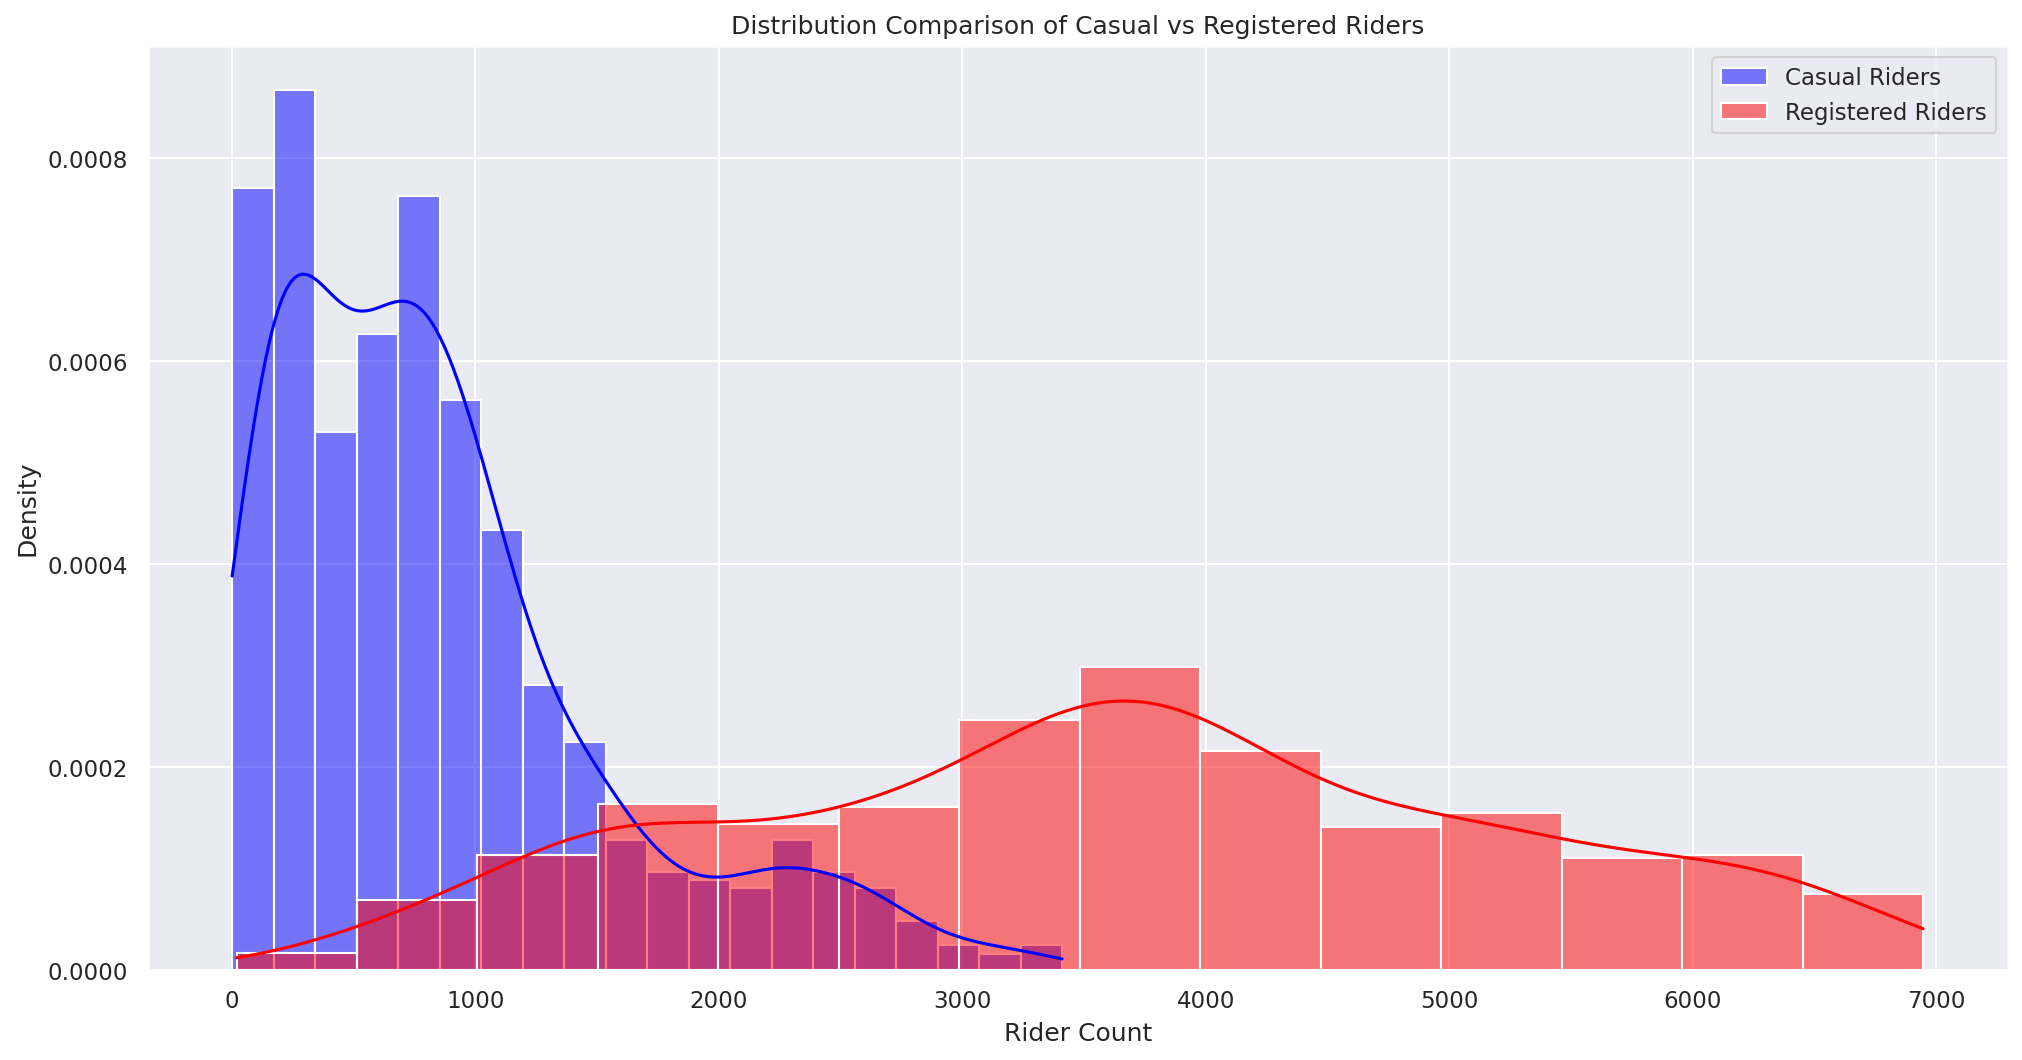

In [12]:
sns.histplot(daily_counts['casual'], color = 'blue', label = 'Casual Riders', stat = 'density', kde = True)
sns.histplot(daily_counts['registered'], color = 'red', label = 'Registered Riders', stat = 'density', kde = True)
plt.xlabel("Rider Count")
plt.ylabel("Density")
plt.title("Distribution Comparison of Casual vs Registered Riders")
plt.legend()

<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

<br>

--- 
### Part 2

In the cell below, describe the differences you notice between the density curves for casual and registered riders.  

- Consider concepts such as modes, symmetry, skewness, tails, gaps, and outliers. 

- Include a comment on the spread of the distributions. 

The density curve for casual rider is skewed to the right and has a prominent peak at a lower rider count. Also, the casual rider density drops off quickly after 2000 riders with few extreme outliers. On the other hand, the density curve for registered riders is more symmetric and peaks at a higher count. Also, the registered rider density has a longer and thicker right tail.
Casual riders show a more concentrated spread while the registered riders have a much wider spread.

<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

<br>

--- 
### Part 3

The density plots do not show how the counts for `registered` and `casual` riders vary together. 

Use `sns.lmplot` [(documentation)](https://seaborn.pydata.org/generated/seaborn.lmplot.html) to create a scatter plot to investigate the relationship between casual and registered counts. 

- Use the `bike` `DataFrame` to plot hourly counts instead of daily counts.
- Color the points in the scatter plot according to whether or not the day is a working day. Your colors do not have to match ours exactly, but they should be different based on whether the day is a working day. 



Text(0.5, 1.0, 'Scatter Plot of Casual vs. Registered Riders (Hourly)')

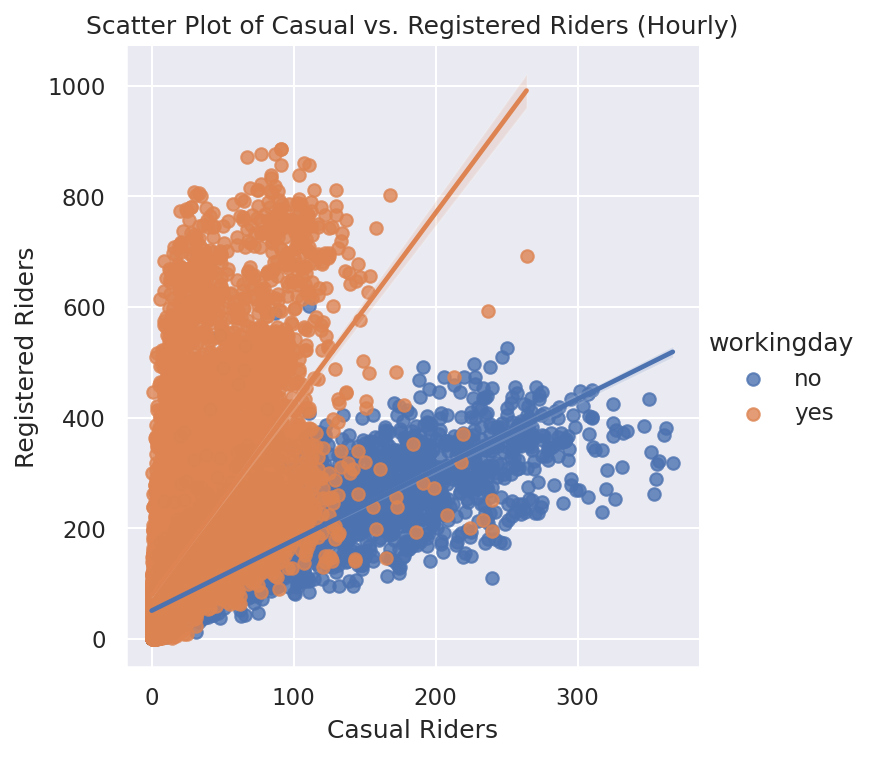

In [19]:
sns.set(font_scale=1) # This line automatically makes the font size a bit bigger on the plot. You do not need to change this line
sns.lmplot(data = bike, x = 'casual', y = 'registered', hue = 'workingday')
plt.xlabel("Casual Riders")
plt.ylabel("Registered Riders")
plt.title("Scatter Plot of Casual vs. Registered Riders (Hourly)")

<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

<br>

--- 
### Part 4

What does this scatterplot seem to reveal about the relationship (if any) between casual and registered riders and whether or not the day is on the weekend? 

What effect does overplotting have on your ability to describe this relationship?

I think this scatterplot reveals that casual riders tend to visit more on non working days. However, the registered riders visit more on working days. The overplotting occurring in the following plot makes it difficult to distinguish individual points. It made me hard to recognize the pattern and the trends.

<!-- END QUESTION -->

<hr style="border: 1px solid #fdb515;" />

## Section 4: Visualization
 
To address overplotting, i'll try visualizing the data with another technique, the bivariate kernel density estimate. I will want to read up on the documentation for `sns.kdeplot`, which can be found [here](https://seaborn.pydata.org/generated/seaborn.kdeplot.html). 

The result I wish to achieve should be a plot that looks like this:

A basic KDE plot of all the data is quite easy to generate (see below). However, this plot combines both weekend and weekday data, which isn't what we want (see the example figure above).

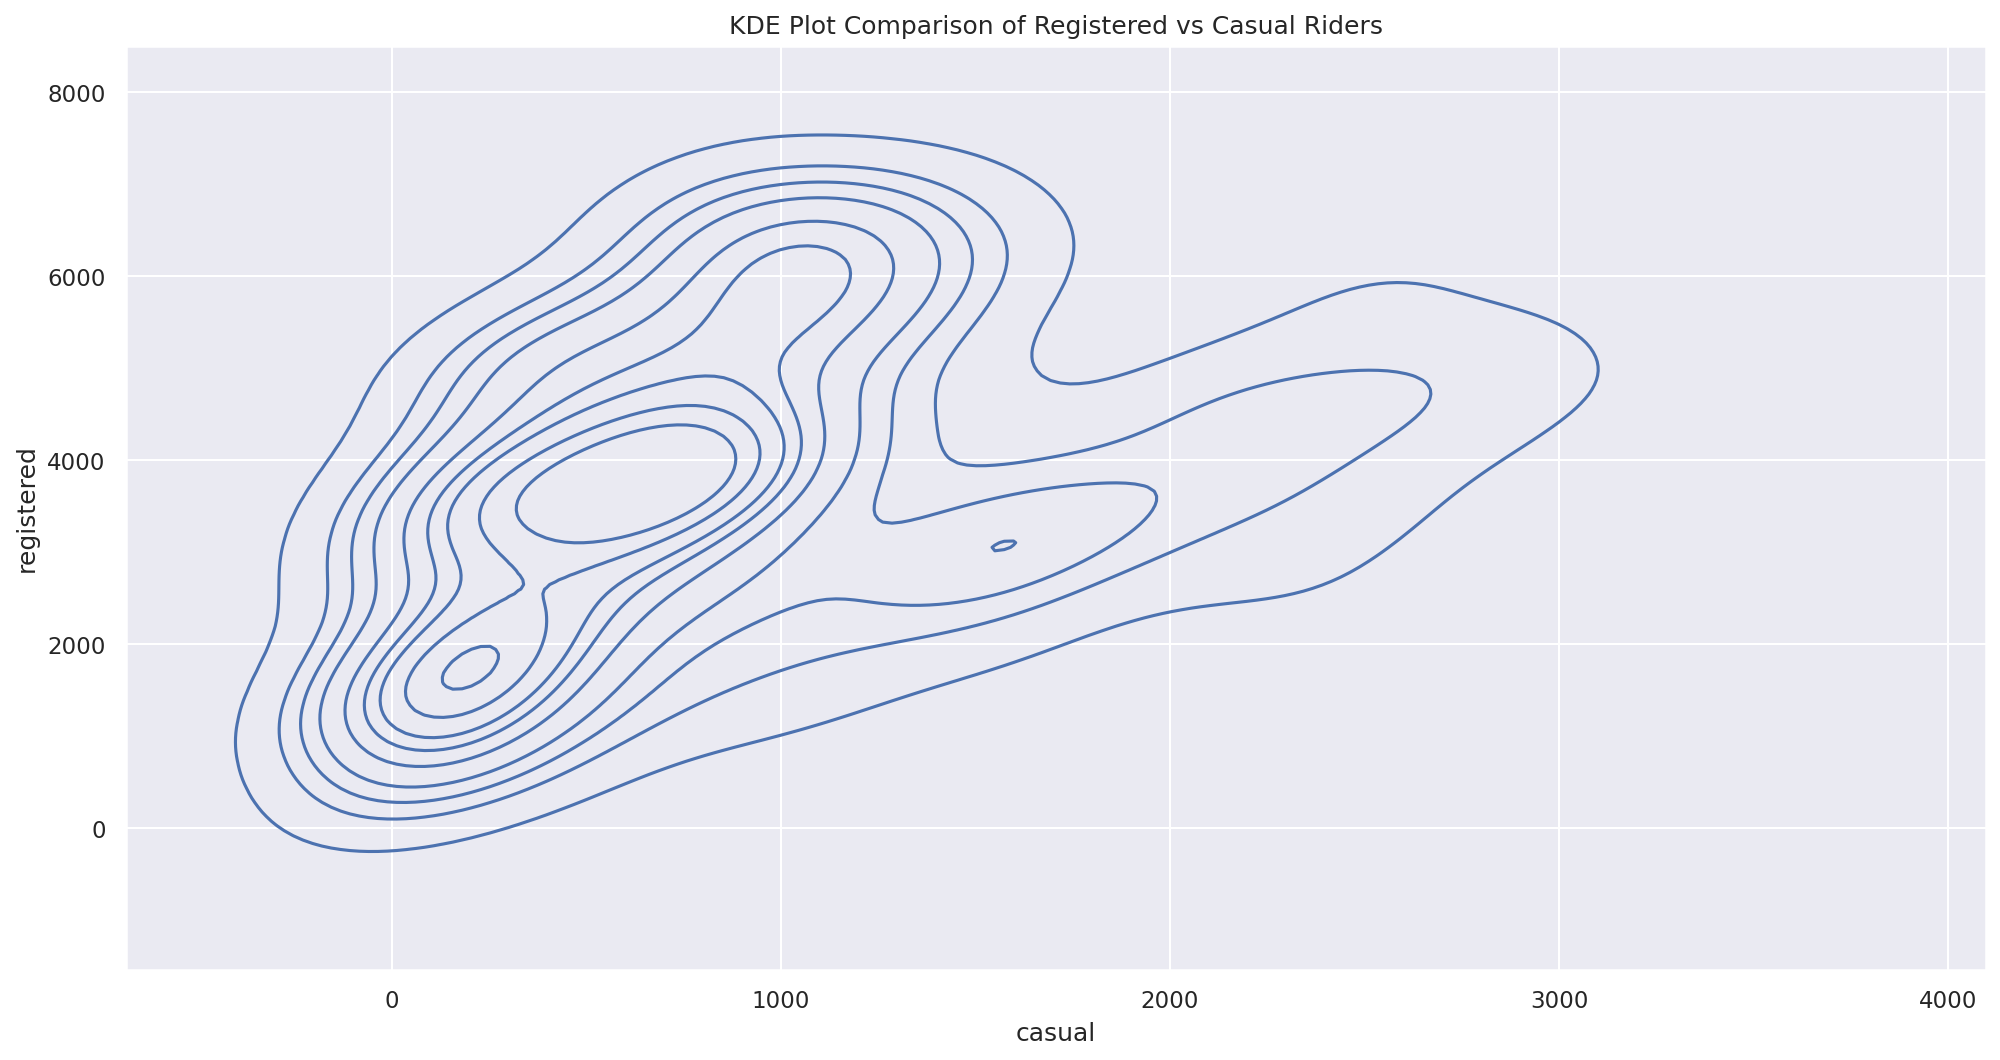

In [14]:
sns.kdeplot(data=daily_counts, x='casual', y='registered')
plt.title('KDE Plot Comparison of Registered vs Casual Riders');

<!-- BEGIN QUESTION -->

<br>

--- 

### Part 1

I will Generate a bivariate kernel density plot with workday and non-workday separated using the `daily_counts` `DataFrame`.

<Axes: xlabel='casual', ylabel='registered'>

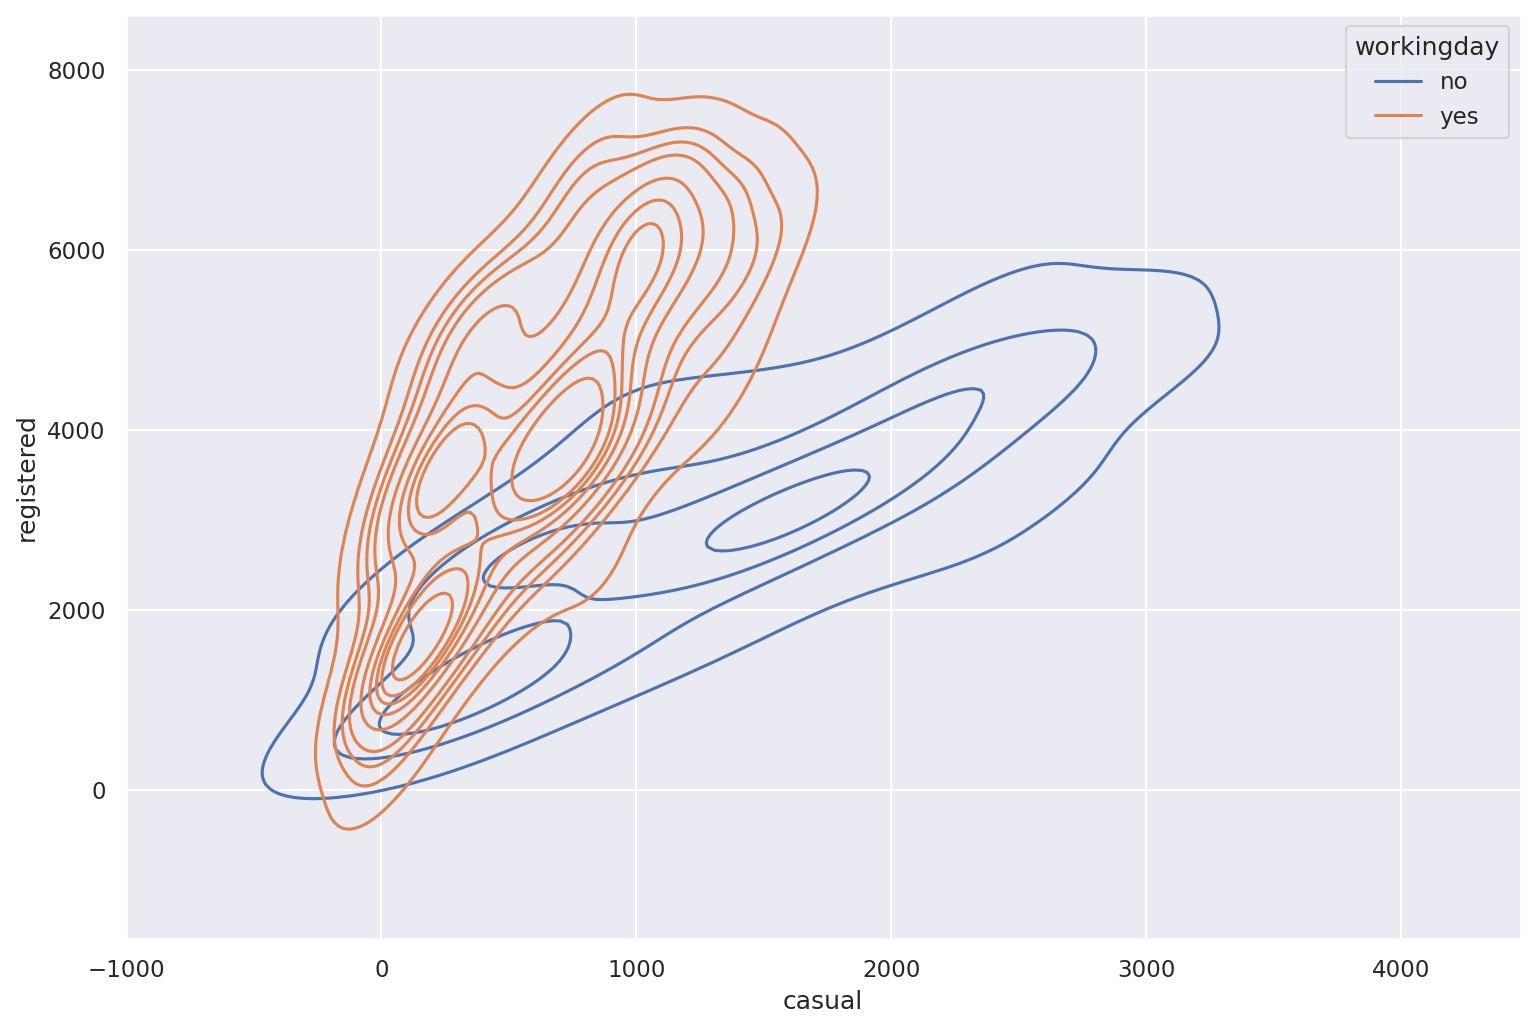

In [23]:
# Set the figure size for the plot
plt.figure(figsize=(12,8))
sns.kdeplot(data = daily_counts, x = 'casual', y = 'registered', hue = 'workingday', fill = False)

<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

<br>

--- 
### Part 2

What additional details about the riders can you identify from this contour plot that were difficult to determine from the scatter plot?

The problem with overplotting on the scatterplot made it hard to identify the frequent combinations of casual and registered riders, but the contour plot made it easier to identify through identifying the darker regions.

<!-- END QUESTION -->

<hr style="border: 1px solid #fdb515;" />

## Section 5: Understanding Daily and Monthly Patterns

<br>

--- 

### Part 1
Create a new column in the `bike` `DataFrame` called `time_category`, which maps the `hr` column into the following broader time categories:

- **Midnight**: 2 AM to before 5 AM  
- **Morning**: 5 AM to before 11 AM  
- **Lunch Time**: 11 AM to before 2 PM  
- **Afternoon**: 2 PM to before 5 PM  
- **Evening**: 5 PM to before 9 PM  
- **Night**: 9 PM to before 2 AM  

Then, display the first few rows of the updated `DataFrame` to verify that the new column is correctly added.

In [32]:
def hour_to_category(hr):
    if 2 <= hr < 5:
        return "Midnight"
    elif 5 <= hr < 11:
        return "Morning"
    elif 11 <= hr < 14:
        return "Lunch Time"
    elif 14 <= hr < 17:
        return "Afternoon"
    elif 17 <= hr < 21:
        return "Evening"
    else:
        return "Night"
bike["time_category"] = bike['hr'].apply(hour_to_category)

bike.head()

,instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt,time_category
0,1,2011-01-01,1,0,1,0,no,Sat,no,Clear,0.24,0.2879,0.81,0.0,3,13,16,Night
1,2,2011-01-01,1,0,1,1,no,Sat,no,Clear,0.22,0.2727,0.80,0.0,8,32,40,Night
2,3,2011-01-01,1,0,1,2,no,Sat,no,Clear,0.22,0.2727,0.80,0.0,5,27,32,Midnight
3,4,2011-01-01,1,0,1,3,no,Sat,no,Clear,0.24,0.2879,0.75,0.0,3,10,13,Midnight
4,5,2011-01-01,1,0,1,4,no,Sat,no,Clear,0.24,0.2879,0.75,0.0,0,1,1,Midnight


<!-- BEGIN QUESTION -->

<br>

--- 
### Part 2

I'll examine the behavior of riders by plotting the **average number of riders** for each **time category** (using the `time_category` column), separated by rider type.                                                                 

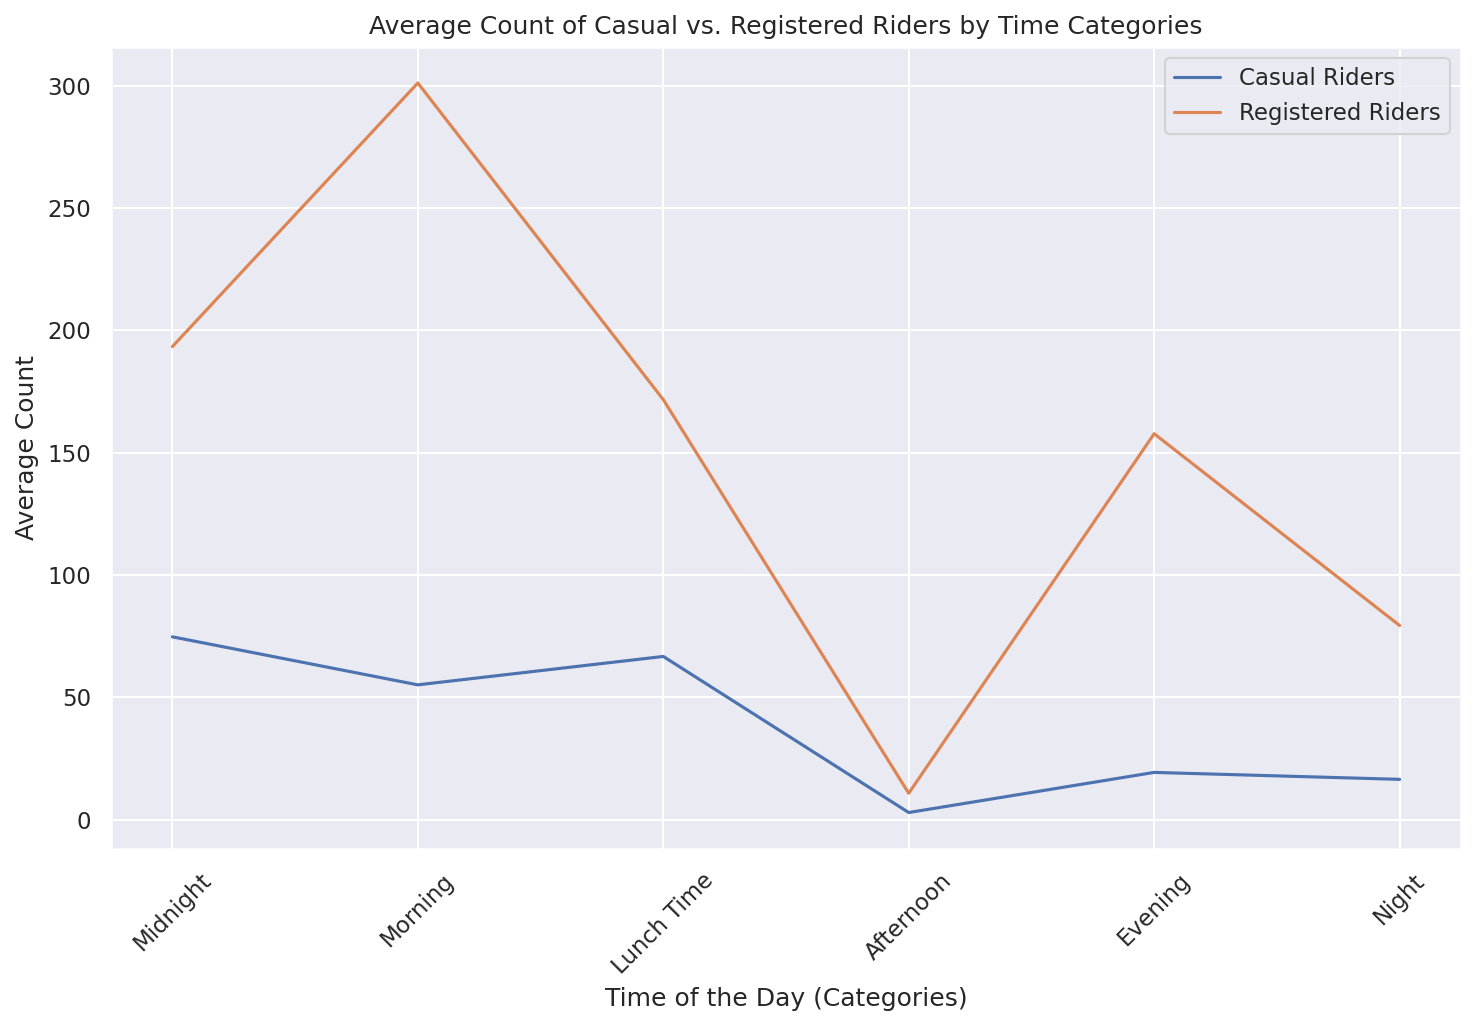

In [34]:
# Group by time category and calculate means
time_category_means = (
    bike.groupby("time_category")[["casual", "registered"]].mean()
)

plt.figure(figsize=(10, 7))
sns.lineplot(
    data=time_category_means.reset_index(),
    x="time_category",
    y="casual",
    label="Casual Riders",
)
sns.lineplot(
    data=time_category_means.reset_index(),
    x="time_category",
    y="registered",
    label="Registered Riders",
)

plt.xlabel("Time of the Day (Categories)")
plt.ylabel("Average Count")
plt.title("Average Count of Casual vs. Registered Riders by Time Categories")
plt.xticks(
    ticks=range(len(time_category_means)),  # Order categories
    labels=["Midnight", "Morning", "Lunch Time", "Afternoon", "Evening", "Night"],
    rotation=45 # Rotate x-axis labels for readability
)  
plt.legend()
plt.tight_layout()

<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

<br>

--- 
### Part 3

Next, analyze how the average count of casual and registered riders varies by month (`mnth`). 

Compute the average number of casual and registered riders for each month in the dataset and create a line plot showing the trends.


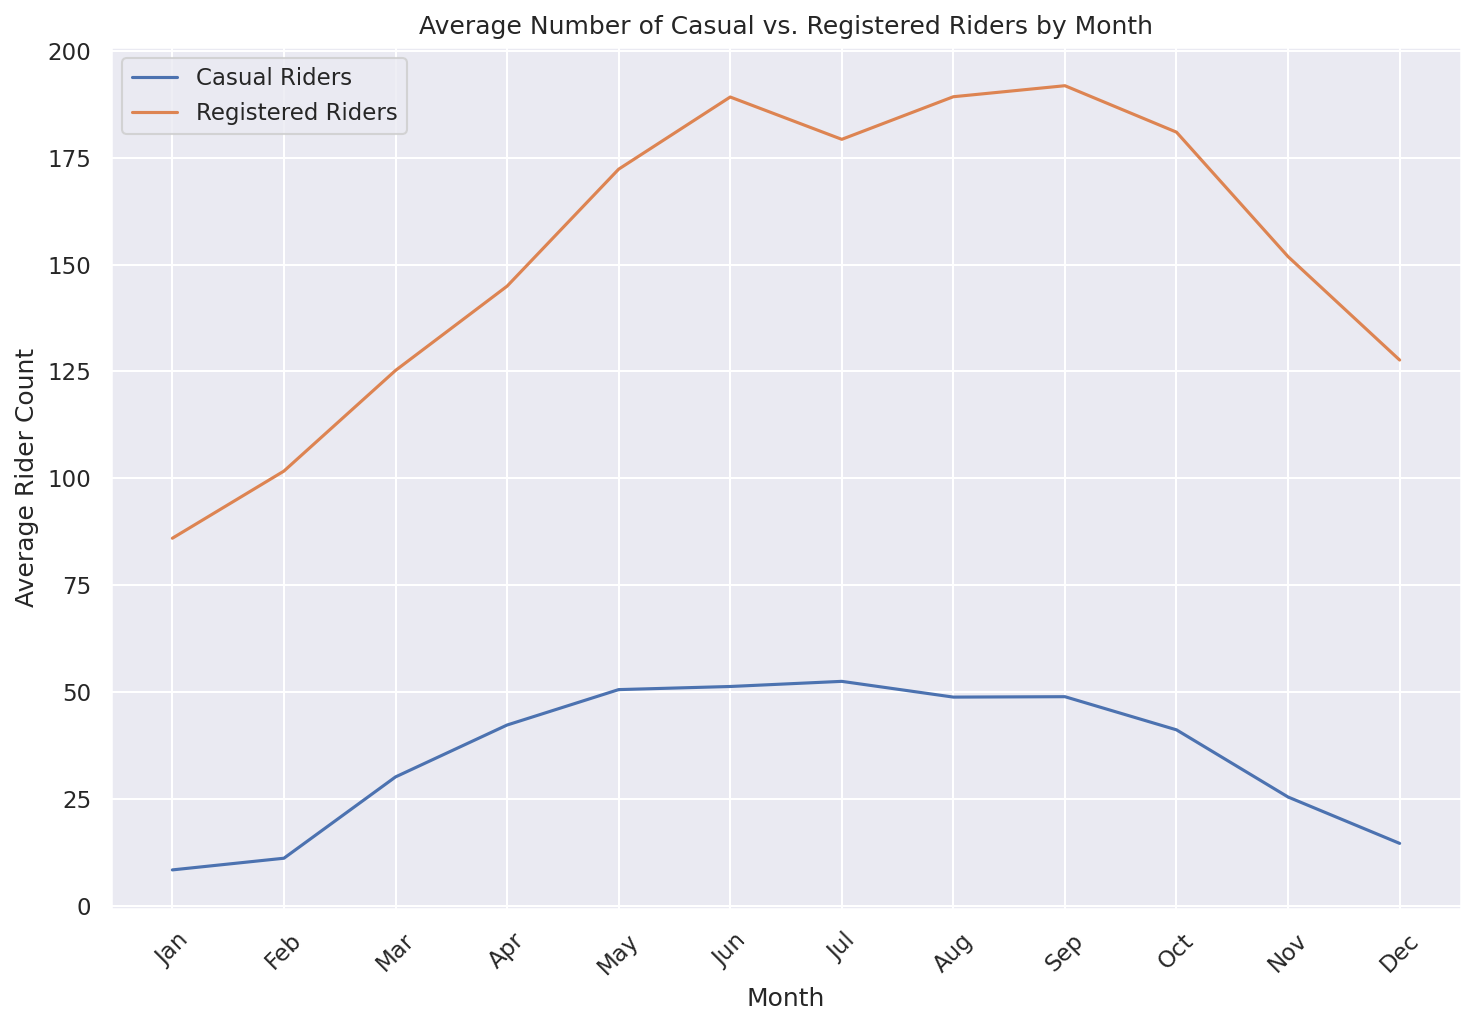

In [35]:
# Group by month and calculate mean rider counts
avg_riders_by_month = bike.groupby("mnth")[["casual", "registered"]].mean()

plt.figure(figsize=(10, 7))

# Plot casual riders
sns.lineplot(
    data=avg_riders_by_month.reset_index(),
    x="mnth",
    y="casual",
    label="Casual Riders"
)

# Plot registered riders
sns.lineplot(
    data=avg_riders_by_month.reset_index(),
    x="mnth",
    y="registered",
    label="Registered Riders"
)

# Formatting
plt.xlabel("Month")
plt.ylabel("Average Rider Count")
plt.title("Average Number of Casual vs. Registered Riders by Month")
plt.xticks(
    ticks=range(1, 13),  # Months range from 1 to 12
    labels=[
        "Jan", "Feb", "Mar", "Apr", "May", "Jun",
        "Jul", "Aug", "Sep", "Oct", "Nov", "Dec"
    ],
    rotation=45  # Rotate x-axis labels for readability
)
plt.legend()
plt.tight_layout()

<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

<br>

--- 
### Part 4

What can I observe from the plots generated in **part 2** and **part 3**? 

From the plot generated in 5b, we can see that most of the registered riders visit in the morning while the average count drops to nearly 0 in the afternoon. For the casual riders, most people visit in the midnight and lunch time. Also, like the registered riders, the average count is lowest in the afternoon.
From the plot generated in 5c, we can see that the average rider count is always larger for the registered riders throughout the year. The average count for the registered riders varies a lot while the average count for casual riders are quite consistent. 

<!-- END QUESTION -->

<hr style="border: 1px solid #fdb515;" />

## Section 6: Exploring Ride-Sharing and Weather
Now i'll examine how the weather may be associated. First, i'll look at how the proportion of casual riders changes as the weather changes.

<br>

--- 

### Part 1
Create a new column `prop_casual` in the `bike` `DataFrame` representing the proportion of casual riders out of all riders for each record.

In [36]:
bike['prop_casual'] = bike['casual'] / (bike['casual'] + bike['registered'])


In order to examine the relationship between the proportion of casual riders and temperature, I can create a scatterplot using [`sns.scatterplot`](https://seaborn.pydata.org/generated/seaborn.scatterplot.html). 

- I can even use color/hue to encode the information about the day of the week. 

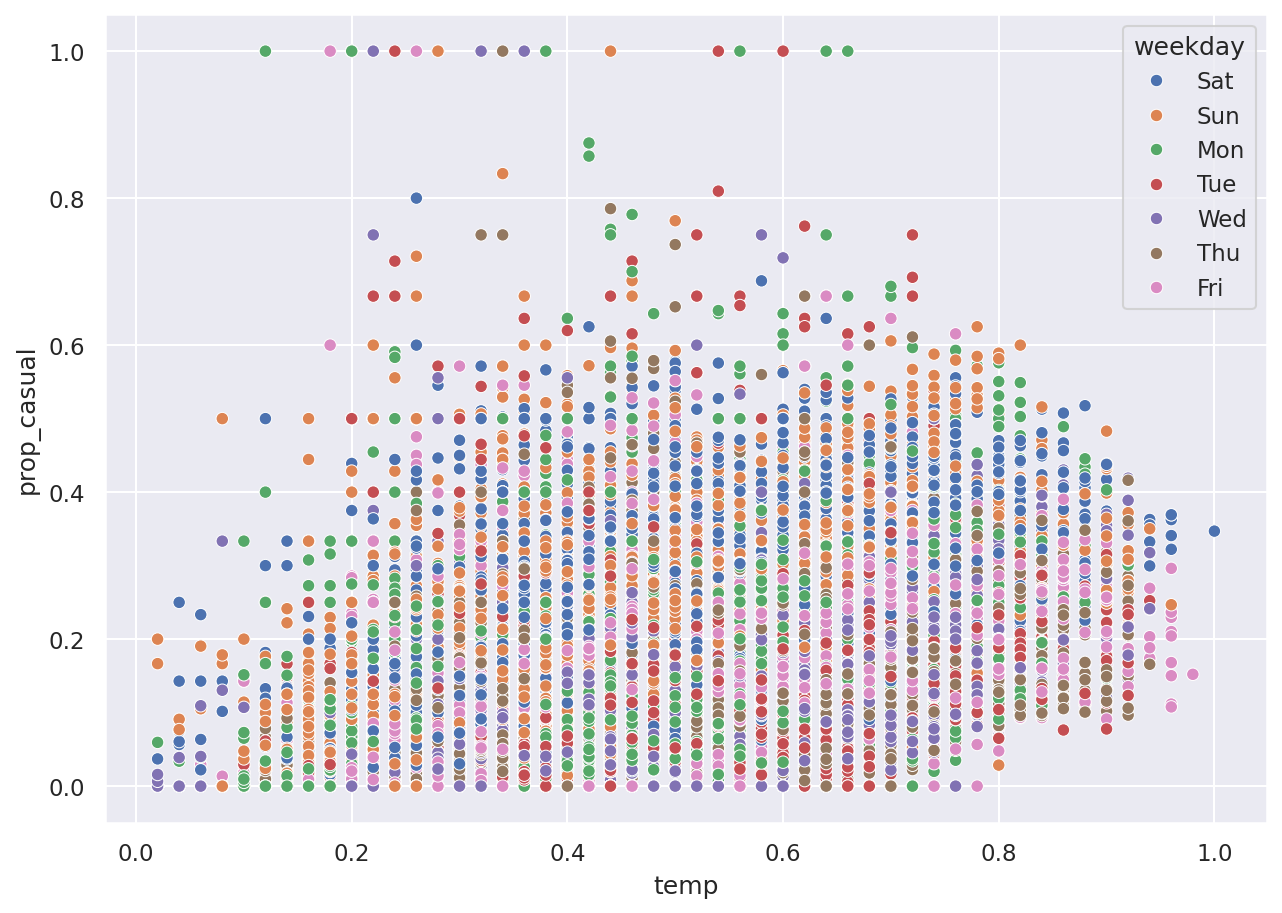

In [38]:
plt.figure(figsize=(10, 7))
sns.scatterplot(data=bike, x='temp', y='prop_casual', hue='weekday');

I could attempt linear regression using `sns.lmplot` as shown below, which hints at some relationships between temperature and proportional casual, but the plot is still fairly unconvincing. 

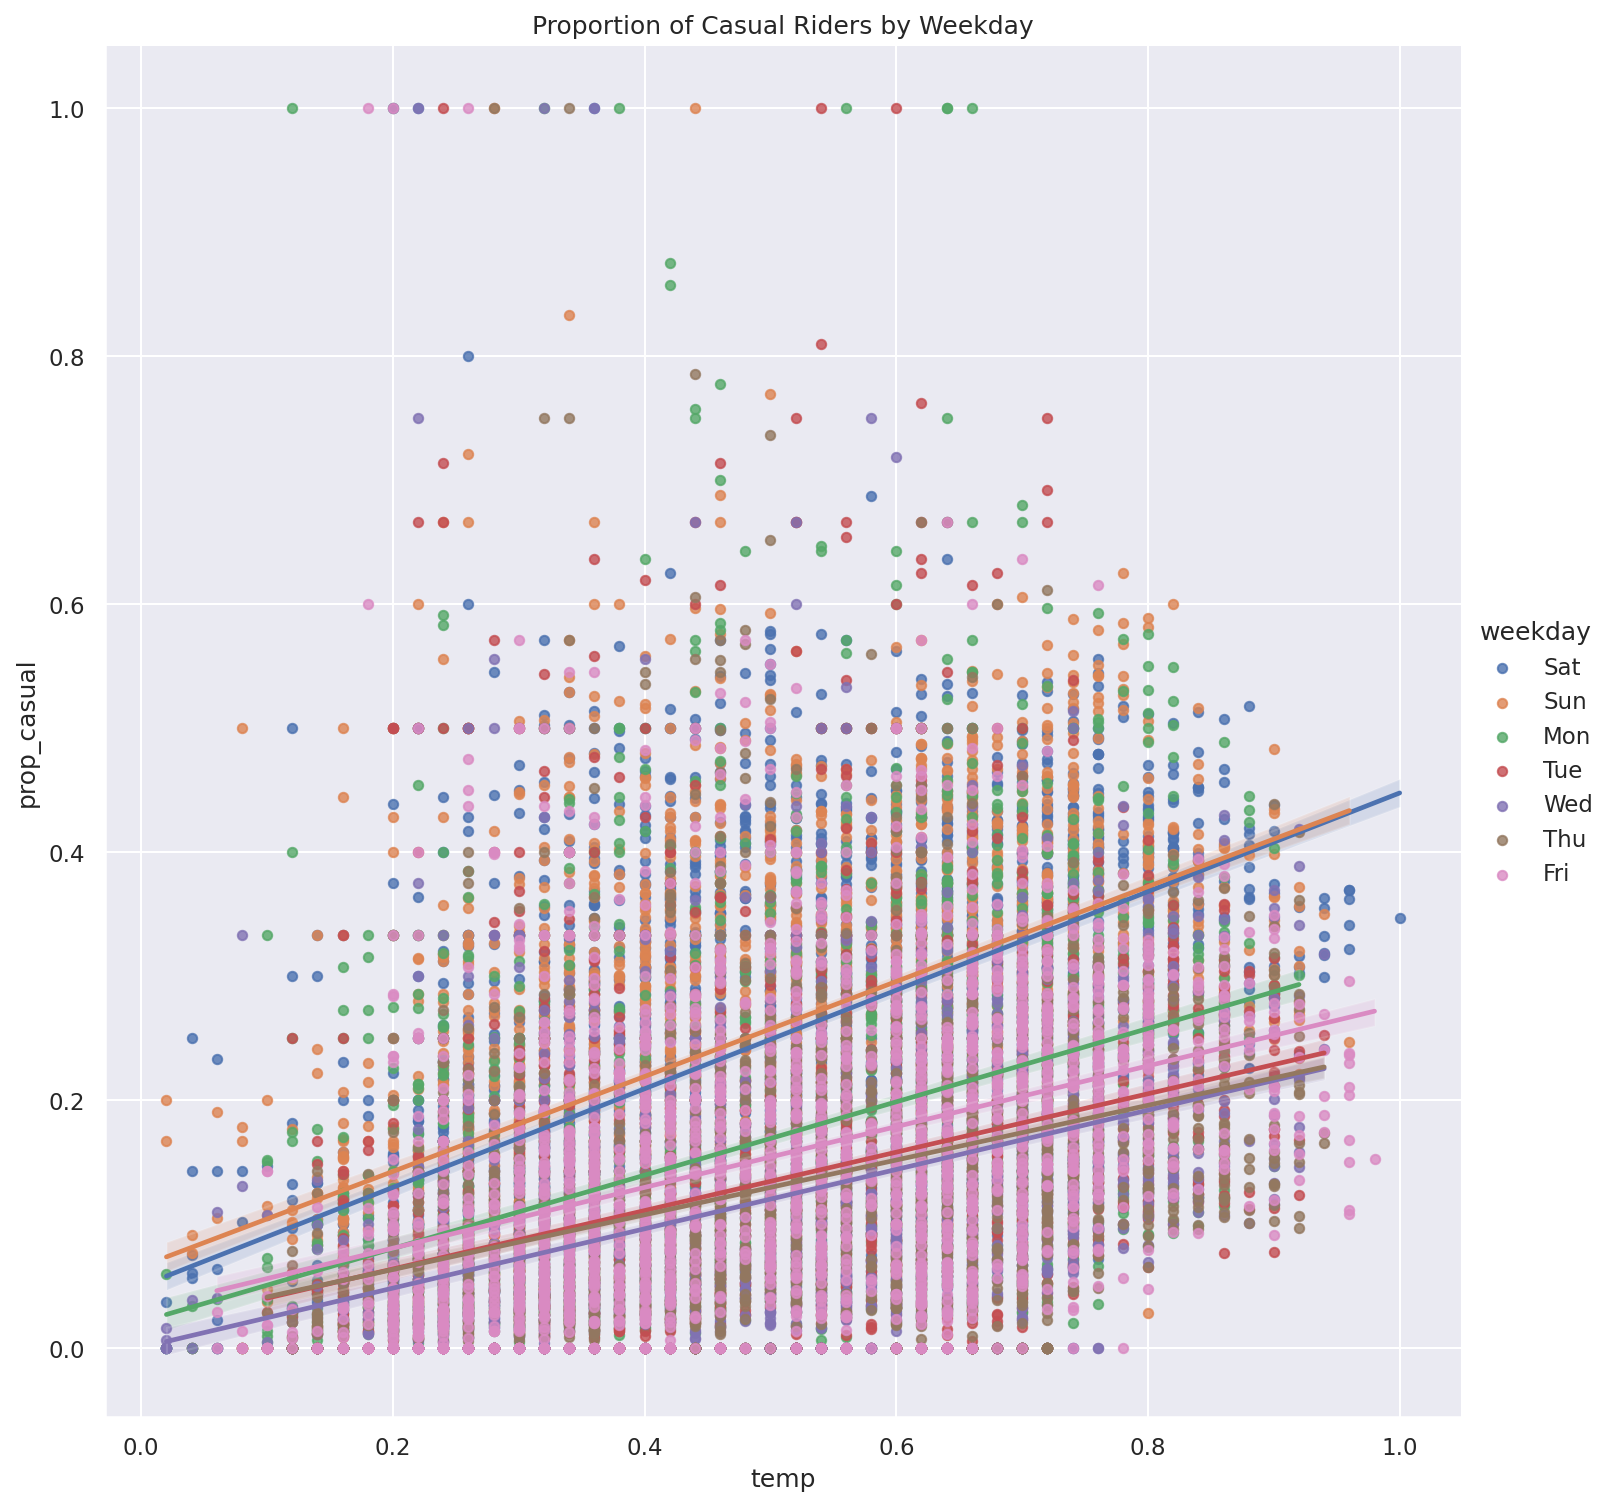

In [39]:
sns.lmplot(data=bike, x='temp', y='prop_casual', hue='weekday', scatter_kws={"s": 20}, height=10)
plt.title("Proportion of Casual Riders by Weekday");

A better approach to visualize the relationship between temperature and the proportion of casual riders is to use local smoothing techniques.

- The basic idea is to compute a representative `y` value for each `x` value that captures the data close to that `x` value.

- One such technique is "Locally Weighted Scatterplot Smoothing" (LOWESS/LOESS). 

Below is an example where the red curve represents a smoothed pattern in the scatterplot.

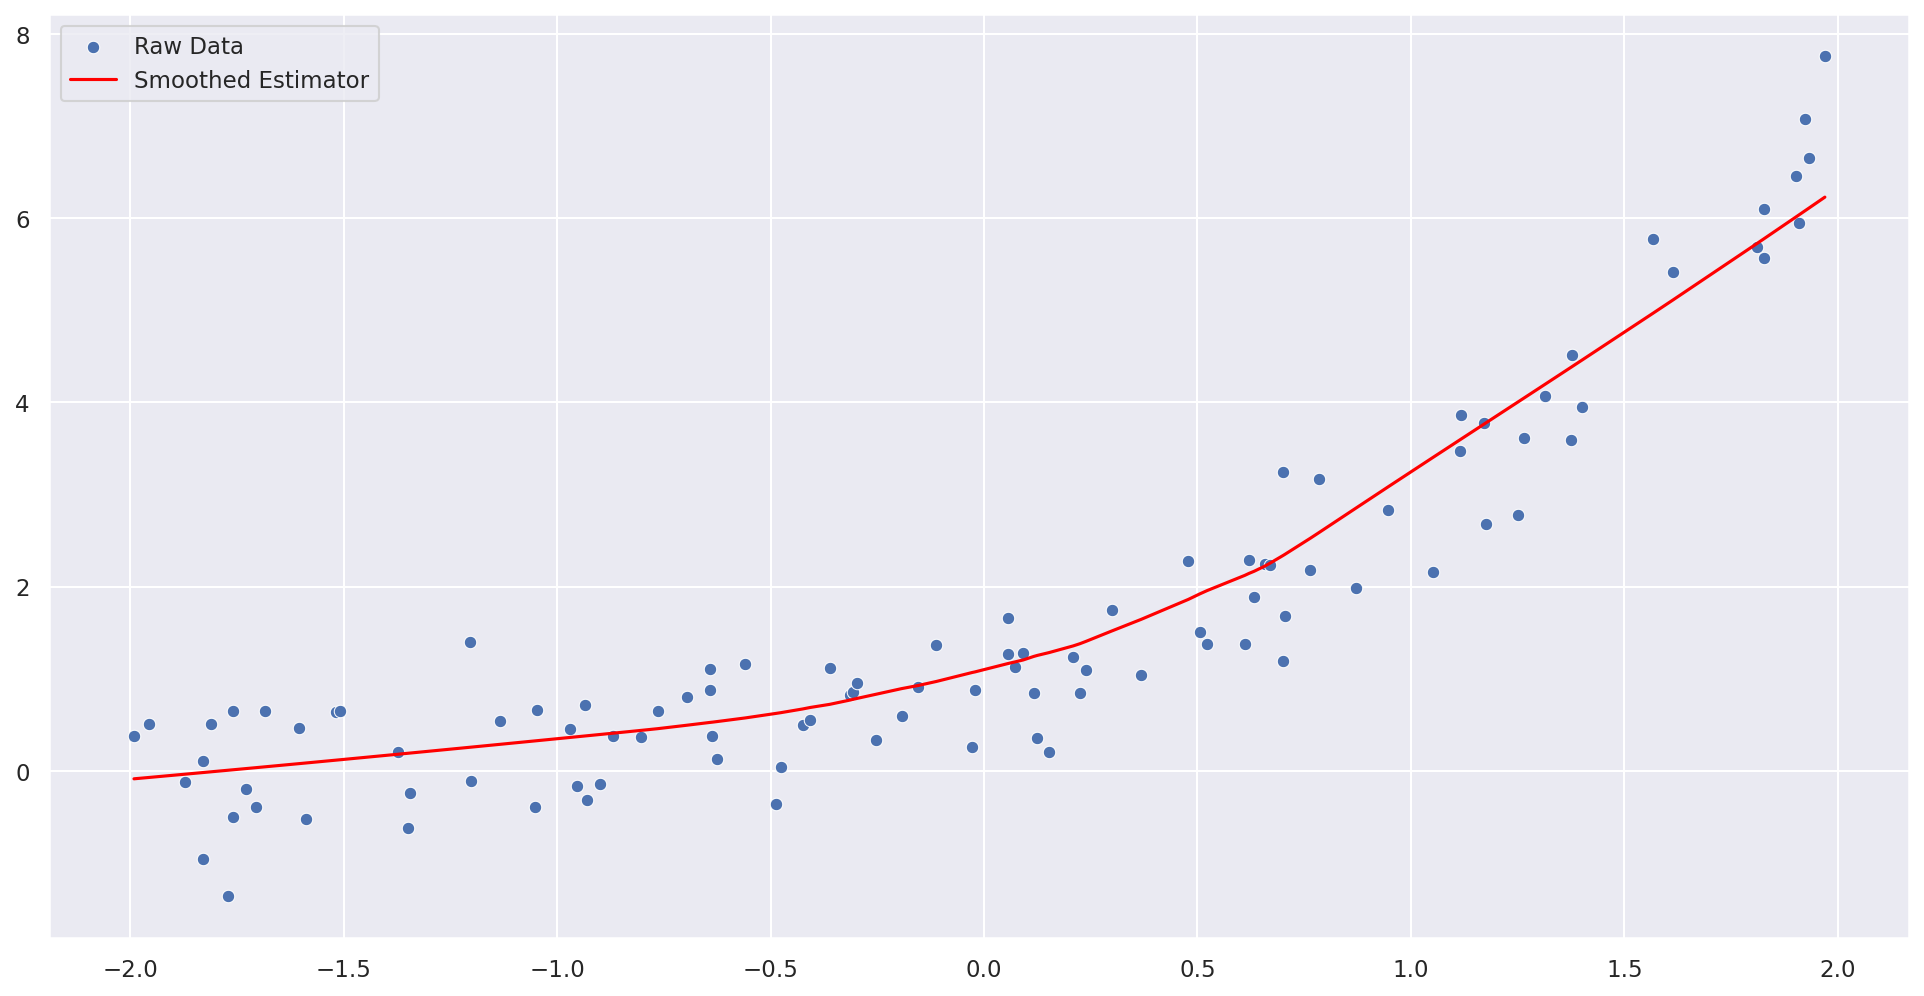

In [40]:
from statsmodels.nonparametric.smoothers_lowess import lowess
# Make noisy data
x_obs = np.sort(np.random.rand(100)*4.0 - 2)
y_obs = np.exp(x_obs) + np.random.randn(100) / 2.0

# Plot a regular scatterplot with our noisy data 
sns.scatterplot(x=x_obs, y=y_obs, label="Raw Data")

# Pass in the noisy data to lowess to generate the smoothed y-values, 
# we want to preserve the relative ordering of the y-values, which is why return_sorted=False
y_smooth = lowess(y_obs, x_obs, return_sorted=False)

# Plot a red line using the smoothed y-values
sns.lineplot(x=x_obs, y=y_smooth, label="Smoothed Estimator", color='red')
plt.legend();

<!-- BEGIN QUESTION -->

<br>

--- 
### Part 2

Draw 7 smoothed curves on a single plot, one for each day of the week. 

- The x-axis should be the temperature (as given in the `'temp'` column).

- The y-axis should be a smoothed version of the proportion of casual riders. 

I should use [`statsmodels.nonparametric.smoothers_lowess.lowess`](http://www.statsmodels.org/dev/generated/statsmodels.nonparametric.smoothers_lowess.lowess.html) just like the example above. 

- Unlike the example above, plot ONLY the lowess curve. Do not plot the actual data, which would result in overplotting. 

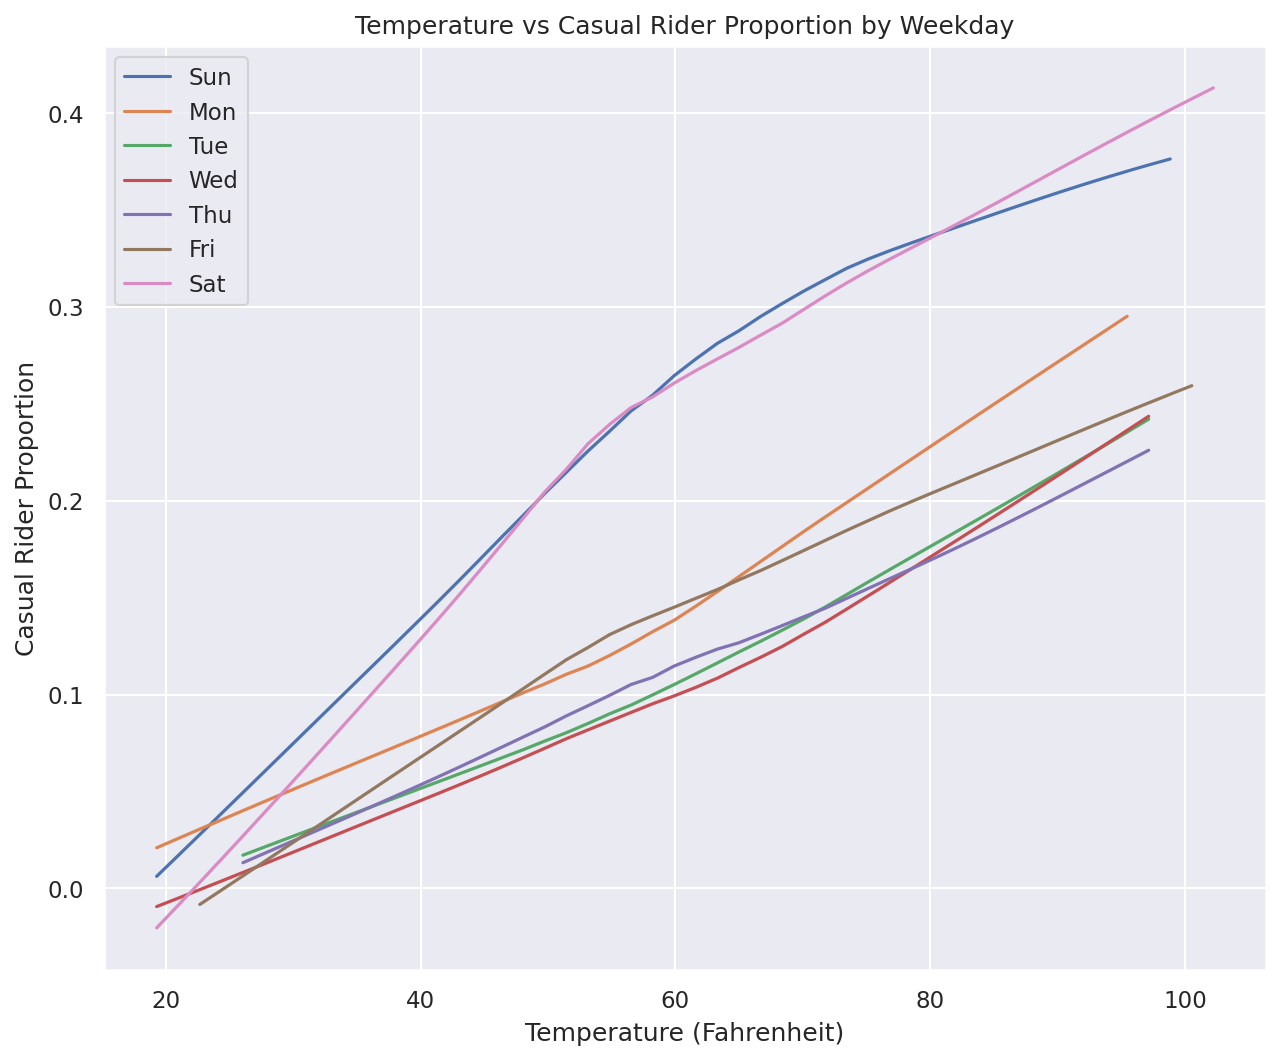

In [42]:
from statsmodels.nonparametric.smoothers_lowess import lowess

plt.figure(figsize=(10,8))
bike['temp_F'] = bike['temp'] * (39 - (-8)) + (-8)
bike['temp_F'] = (bike['temp_F'] * 9/5) + 32

weekday_labels = ['Sun', 'Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat']

for day in weekday_labels:
    day_data = bike[bike['weekday'] == day]
    smoothed = lowess(day_data['prop_casual'], day_data['temp_F'], return_sorted=False)
    
    sns.lineplot(x = day_data['temp_F'], y=smoothed, label=day)

plt.xlabel("Temperature (Fahrenheit)")
plt.ylabel("Casual Rider Proportion")
plt.title("Temperature vs Casual Rider Proportion by Weekday")
plt.legend()


<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

<br>

--- 
### Part 3
Examine the plot above and describe how casual ridership changes with temperature. Determine if the **plot alone** provides evidence of a **causal** relationship between temperature and casual ridership, and explain your reasoning. 

Finally, based on **your own intuition**, state whether you think there is a underlying causal relationship. Justify your answer. 

The casual ridership increases as the temperature increases. But the plot alone does not provide evidence of a causal relationship. That is because this is an observational study and there might be other confounding factors influencing the relationship between the temperature and casual ridership.

<!-- END QUESTION -->



<!-- END QUESTION -->

